# Introduction
We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Cen‐
sus Bureau. Each image is labeled with the digit it represents. This set has been stud‐
ied so much that it is often called the “Hello World” of Machine Learning: whenever
people come up with a new classification algorithm, they are curious to see how it
will perform on MNIST. Whenever someone learns Machine Learning, sooner or
later they tackle MNIST.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
X, y = mnist["data"], mnist["target"]
print("Features:", X.shape)
print("Target:", y.shape)

Features: (70000, 784)
Target: (70000,)


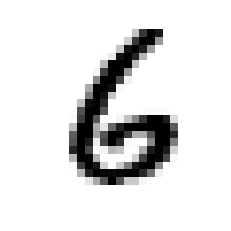

In [4]:
some_digit = X[6000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
'''The above one looks like 9, lets verify'''
print(y[6000])

6


In [6]:
'''
The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)
'''
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
'''
Let’s also shuffle the training set. 
This will guarantee that all cross-validation folds will be similar'''
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

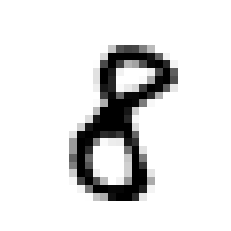

In [8]:
some_digit = X_train[5000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
print(y_train[5000])

8


In [10]:
'''Training a Binary Classifier for one digit only 5'''
y_train_4 = (y_train == '4')
y_test_4 = (y_test == '4')
num_of_true = (y_train_4 == True).sum()
num_of_false = (y_train_4 == False).sum()
print("Total True:", num_of_true)
print("Total False:", num_of_false)

Total True: 5842
Total False: 54158


In [11]:
'''Start with SGDClassifier'''
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
'''Predict a digit'''
sgd_clf.predict(X_train[9].reshape(1, -1))

array([ True])

In [13]:
'''Predict another digit'''
sgd_clf.predict(X_train[5000].reshape(1, -1))

array([False])

In [14]:
'''Implementing Cross-Validation'''
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_4[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_4[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9772511374431279
0.9785
0.9780489024451222


In [15]:
'''Lets use the cross_val_score() function to evaluate your SGDClassifier model 
using K-fold cross-validation, with three folds.'''
cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.97725114, 0.9785    , 0.9780489 ])

In [16]:
'''Lets look at a very dumb classifier 
that just classifies every single image in the “not-4” class'''
class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_4_clf = Never4Classifier()
cross_val_score(never_4_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.906 , 0.9008, 0.9011])

In [17]:
'''
Create Confusion Matrix:
Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
tive class): 53,272 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,307 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,077 were wrongly
classified as non-5s (false negatives), while the remaining 4,344 were correctly classi‐
fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):
'''
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)
confusion_matrix(y_train_4, y_train_pred)

array([[53676,   482],
       [  842,  5000]])

In [18]:
'''Precision Score'''
precision_score(y_train_4, y_train_pred)

0.9120758847136081

In [19]:
'''Recall Score'''
recall_score(y_train_4, y_train_pred)

0.8558712769599452

In [20]:
'''F1 Score'''
f1_score(y_train_4, y_train_pred)

0.8830801836806782

In [21]:
'''Decision Function'''
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-10444.70642069]


In [22]:
'''Set the threshold'''
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [23]:
'''Compute the threshold'''
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)
print("Precisions:", precisions, "Recalls:", recalls, "Thresholds:", thresholds)

Precisions: [0.10702182 0.10700546 0.10700742 ... 1.         1.         1.        ] Recalls: [1.00000000e+00 9.99828826e-01 9.99828826e-01 ... 3.42348511e-04
 1.71174255e-04 0.00000000e+00] Thresholds: [-53642.80345535 -53639.61983201 -53636.26401417 ...  41349.17877548
  41385.79816809  41701.68688547]


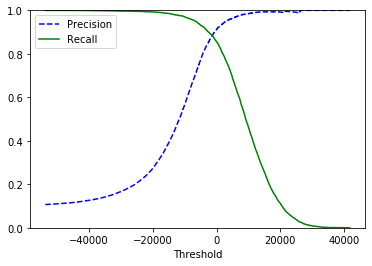

In [24]:
'''Plot precision and recall as functions of the threshold value using Matplotlib'''
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

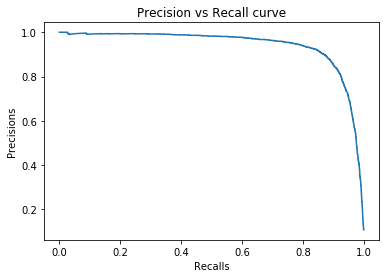

In [25]:
'''Another way to select a good precision/recall tradeoff is to plot
precision directly against recall'''
plt.plot(recalls, precisions, linestyle='solid')
plt.title("Precision vs Recall curve")
plt.xlabel("Recalls")
plt.ylabel("Precisions");
plt.show()

In [26]:
'''Lets suppose you decide to aim for 90% precision. You look up the first plot
(zooming in a bit) and find that you need to use a threshold of about 70,000. To make
predictions (on the training set for now), instead of calling the classifier’s predict()
method, you can just run this code'''
y_train_pred_90 = (y_scores > 10000)
precision_score(y_train_4, y_train_pred_90)

0.9854227405247813

In [27]:
recall_score(y_train_4, y_train_pred_90)

0.4628551865799384

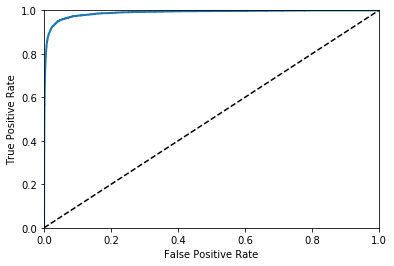

In [28]:
'''Plot the ROC curve'''
fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
'''Calculate AUC'''
roc_auc_score(y_train_4, y_scores)

0.9886097942420847

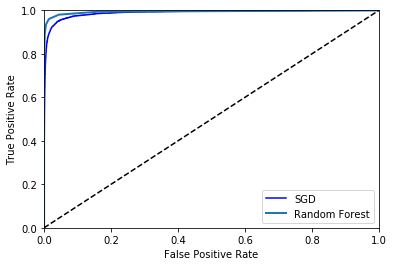

In [30]:
'''Implement a Random Forest Classifier and compare with SGD Classifier'''
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=4, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4,y_scores_forest)

plt.plot(fpr, tpr, "b", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

In [31]:
'''AUC of Random Forest'''
roc_auc_score(y_train_4, y_scores_forest)

0.993811567720901

In [32]:
'''Multinomial Classifier'''
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['8'], dtype='<U1')

In [33]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-29388.2565329   -7637.27435173 -10320.63216905  -1784.99128993
   -9597.63807793  -5359.97016733 -20034.09900362 -23063.89256463
    3546.10020951  -4261.10940687]]


In [34]:
np.argmax(some_digit_scores)

8

In [35]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [36]:
sgd_clf.classes_[2]

'2'

In [37]:
'''Force OvO'''
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['8'], dtype=object)

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
'''Training a RandomForestClassifier'''
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['8'], dtype=object)

In [40]:
'''See the list of probabilities that the classifier assigned to each
instance for each class'''
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [41]:
'''Now evaluate the classifiers: SGD Classifier'''
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8624775 , 0.87574379, 0.8593289 ])

In [42]:
'''Scale the input'''
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89697061, 0.90414521, 0.89703456])